# Interactive Facial Pose Analysis Pipeline - Unaligned

This notebook is an interactive, step-by-step demonstration of the facial-pose processing pipeline used in this project.
It connects a set of lightweight utilities (in utils/) and the top-level pose_pipeline.py logic into reproducible, inspectable steps so a user can:
- see raw data ingestion,
- inspect how low-confidence OpenPose keypoints are masked and filled,
- verify signal processing choices (interpolation + Butterworth filtering),
- examine normalization to screen coordinates,
- inspect per-frame feature extraction (blink, mouth, head rotation, etc.),
- compute windowed linear metrics for statistical tests,
- and generate publication-ready summary plots and model results.

Input expectation: OpenPose-style CSV files in CFG.RAW_DIR following the naming convention:
`<participantID>_<condition>.csv`

## 1. Data Loading
What this cell does:
- Locates raw OpenPose CSV files in the configured `CFG.RAW_DIR`
- For each raw CSV, detects the naming convention of confidence columns and filters the full OpenPose output down to the small set of facial landmarks we analyze
- Produces a reduced DataFrame that contains only the relevant x/y coordinates and confidence values for the facial keypoints we need.

Inputs: Files in `CFG.RAW_DIR` (see naming conventions above).

Outputs (per file):
- In-memory reduced DataFrame (optionally persisted as `OUT_BASE/reduced/<stem>_reduced.csv` if `SAVE_REDUCED=True`).

In [1]:
from pathlib import Path
import pandas as pd
from utils import CFG
from utils.io_utils import (
    load_raw_files,
    detect_conf_prefix_case_insensitive,
    relevant_indices,
    filter_df_to_relevant,
    parse_participant_condition
)

# ---- interactive controls ----
OVERWRITE = True       # set True to force recompute of reduced files
SAVE_REDUCED = False    # set True if you want reduced CSVs written to disk

# ---- locations ----
raw_files = load_raw_files()   # returns list[Path] from CFG.RAW_DIR
out_dir = Path(CFG.OUT_BASE) / "reduced"
out_dir.mkdir(parents=True, exist_ok=True)

print(f"Found {len(raw_files)} raw CSV(s) in {CFG.RAW_DIR}")
for p in raw_files:
    print("  ", p.name)

# If nothing to do, tell the user
if not raw_files:
    raise FileNotFoundError(f"No raw CSVs found in {CFG.RAW_DIR} — add files named <participantID>_<condition>.csv")
# Compute the canonical relevant indices once
IDX = relevant_indices()

# Process each file: filter to relevant columns; detect conf prefix for later steps
for fp in raw_files:
    reduced_path = out_dir / (fp.stem + "_reduced.csv")
    if reduced_path.exists() and not OVERWRITE:
        print(f"[skip] reduced exists -> {reduced_path}")
        # still load into memory preview below if needed
        df_reduced = pd.read_csv(reduced_path)
    else:
        print(f"[run] filtering -> {fp.name}")
        df_raw = pd.read_csv(fp)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_raw.columns))
        df_reduced = filter_df_to_relevant(df_raw, conf_pref, IDX)
        if SAVE_REDUCED:
            df_reduced.to_csv(reduced_path, index=False)
            print(f"[OK] wrote reduced -> {reduced_path}")
        else:
            print(f"[OK] filtered in-memory (not saved). Set SAVE_REDUCED=True to persist to {reduced_path}")

# Preview first reduced file (in-memory or on-disk)
try:
    display(df_reduced.head())
except Exception:
    print("Preview not available (no reduced dataframe loaded into memory).")


Found 144 raw CSV(s) in data/raw
   3101_H.csv
   3101_L.csv
   3101_M.csv
   3102_L.csv
   3102_M.csv
   3103_L.csv
   3104_H.csv
   3104_L.csv
   3104_M.csv
   3105_H.csv
   3105_L.csv
   3105_M.csv
   3206_H.csv
   3206_L.csv
   3206_M.csv
   3207_H.csv
   3207_L.csv
   3207_M.csv
   3208_H.csv
   3208_L.csv
   3208_M.csv
   3209_H.csv
   3209_L.csv
   3209_M.csv
   3210_H.csv
   3210_L.csv
   3210_M.csv
   3211_H.csv
   3211_L.csv
   3211_M.csv
   3213_H.csv
   3213_L.csv
   3213_M.csv
   3214_H.csv
   3214_L.csv
   3214_M.csv
   3215_H.csv
   3215_L.csv
   3215_M.csv
   3216_H.csv
   3216_L.csv
   3216_M.csv
   3217_H.csv
   3217_L.csv
   3217_M.csv
   3218_H.csv
   3218_L.csv
   3218_M.csv
   3219_H.csv
   3219_L.csv
   3219_M.csv
   3220_H.csv
   3220_L.csv
   3220_M.csv
   3221_H.csv
   3221_L.csv
   3221_M.csv
   3222_H.csv
   3222_L.csv
   3222_M.csv
   3223_H.csv
   3223_L.csv
   3223_M.csv
   3224_H.csv
   3224_L.csv
   3224_M.csv
   3225_H.csv
   3225_L.csv
   3225_M.csv
 

,x28,y28,prob28,x29,y29,prob29,x30,y30,prob30,x31,...,prob63,x67,y67,prob67,x69,y69,prob69,x70,y70,prob70
0,919.076,693.341,0.780755,921.125,718.953,0.825388,923.174,743.540,0.906230,926.247,...,0.855168,902.684,822.425,0.864736,859.656,677.974,0.764685,967.227,694.365,0.825782
1,919.070,693.346,0.782919,921.119,718.959,0.827026,923.168,743.547,0.906158,926.242,...,0.853667,902.678,822.435,0.862980,860.673,677.978,0.765217,967.222,694.370,0.826904
2,918.933,694.091,0.786834,919.953,718.560,0.834511,921.992,743.030,0.908126,926.070,...,0.890637,902.620,822.555,0.902610,859.799,677.778,0.757551,966.852,695.111,0.822884
3,918.938,694.095,0.788332,919.958,718.567,0.834143,921.997,743.038,0.907378,926.075,...,0.893741,902.624,823.590,0.908273,859.798,677.781,0.758855,966.861,695.115,0.821669
4,919.020,694.411,0.790483,919.020,718.999,0.855869,921.069,743.586,0.917644,925.167,...,0.884428,902.628,823.494,0.895774,859.601,678.020,0.759983,967.170,694.411,0.823724


## 2. Clean & Filter Data
What this cell does:
- For each reduced file, masks coordinates below a confidence threshold by setting those coordinates to NaN.
- Interpolates short gaps in coordinates (bounded by MAX_INTERP_RUN) and applies a Butterworth band-limited filter to each x/y series to remove high-frequency noise.
- Normalizes coordinate series to screen coordinates (scales x,y into 0..IMG_WIDTH and 0..IMG_HEIGHT).
- Caches results at each intermediate stage in OUT_BASE so later steps can read cached files instead of recomputing.

Key parameters you can change in the notebook:
- CONF_THRESH (default 0.3) — confidence threshold below which coordinate pairs are masked.
- MAX_INTERP_RUN (default 10 frames) — the maximum length of consecutive NaNs that will be interpolated; longer gaps are left as NaN.
- FILTER_ORDER and CUTOFF_HZ — Butterworth filter order and low-pass cutoff frequency.
- SAVE_MASKED, SAVE_INTERP_FILTERED, SAVE_NORM — toggles to persist intermediate files.
- OVERWRITE — if True, cached files are recomputed even if present.

Inputs:
- Reduced CSVs (from Step 1) or raw CSVs if reduced files are not present.

Outputs:
- masked CSVs (masked coordinates)
- interp_filtered CSVs (interpolated + filtered)
- norm_screen CSVs (normalized coordinates; these are the canonical per-frame files used by feature extraction and viewing)

In [5]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from utils import CFG
from utils.io_utils import detect_conf_prefix_case_insensitive, relevant_indices, filter_df_to_relevant, parse_participant_condition, load_raw_files, confidence_mask
from utils.signal_utils import interpolate_run_limited, butterworth_segment_filter
from utils.normalize_utils import normalize_to_screen

# ---- Interactive toggles ----
VERBOSE = False       # set True to see step-by-step
LOG_EVERY = 10        # emit 1 compact line every N files when not verbose
OVERWRITE = False             # Set True to force recompute of masked/interp/norm files
SAVE_MASKED = False          # Save masked CSVs? (we default to not saving)
SAVE_INTERP_FILTERED = False # Save interpolated+filtered CSVs? (default not saving)
SAVE_NORM = True             # Save normalized CSVs (default: keep this True)

# Optional overrides (if you want to override CFG values)
# If you don't want to override, leave these as None and existing CFG values will be used.
CONF_THRESH = getattr(CFG, "CONF_THRESH", None) or 0.3
MAX_INTERP_RUN = getattr(CFG, "MAX_INTERP_RUN", None) or 10
FILTER_ORDER = getattr(CFG, "FILTER_ORDER", None) or 2
CUTOFF_HZ = getattr(CFG, "CUTOFF_HZ", None) or 6.0

# Apply overrides to CFG so utils use the values consistently
CFG.CONF_THRESH = CONF_THRESH
CFG.MAX_INTERP_RUN = MAX_INTERP_RUN
CFG.FILTER_ORDER = FILTER_ORDER
CFG.CUTOFF_HZ = CUTOFF_HZ

# ---- paths ----
RAW_FILES = load_raw_files()  # uses CFG.RAW_DIR
reduced_dir = Path(CFG.OUT_BASE) / "reduced"
masked_dir = Path(CFG.OUT_BASE) / "masked"
interp_dir = Path(CFG.OUT_BASE) / "interp_filtered"
norm_dir = Path(CFG.OUT_BASE) / "norm_screen"

for d in (masked_dir, interp_dir, norm_dir):
    d.mkdir(parents=True, exist_ok=True)

if not RAW_FILES:
    raise FileNotFoundError(f"No raw CSVs found in {CFG.RAW_DIR} — add files named <participantID>_<condition>.csv")

# Compute canonical indices once
IDX = relevant_indices()

for i, fp in enumerate(tqdm(RAW_FILES, desc="Clean/Filter (files)"), start=1):
    stem = fp.stem
    reduced_p = reduced_dir / (stem + "_reduced.csv")
    msg_parts = [fp.name]  # we'll build one compact line per file

    # Prefer reduced on disk if available; otherwise compute from raw on the fly
    if reduced_p.exists():
        df_reduced = pd.read_csv(reduced_p)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_reduced.columns))
        if VERBOSE: tqdm.write(f"[reduced] cached -> {reduced_p.name}")
        msg_parts.append("reduced=cached")
    else:
        df_raw = pd.read_csv(fp)
        conf_pref = detect_conf_prefix_case_insensitive(list(df_raw.columns))
        df_reduced = filter_df_to_relevant(df_raw, conf_pref, IDX)
        if VERBOSE: tqdm.write(f"[reduced] from raw")
        msg_parts.append("reduced=raw")

    # --- Step 3: Mask by confidence ---
    masked_p = masked_dir / (stem + "_masked.csv")
    if masked_p.exists() and not OVERWRITE:
        df_masked = pd.read_csv(masked_p)
        if VERBOSE: tqdm.write(f"[mask] skip (cached) -> {masked_p.name}")
        msg_parts.append("mask=cached")
    else:
        if VERBOSE: tqdm.write(f"[mask] run")
        df_masked, stats = confidence_mask(df_reduced, conf_pref, IDX, CFG.CONF_THRESH)
        if SAVE_MASKED:
            df_masked.to_csv(masked_p, index=False)
            if VERBOSE: tqdm.write(f"[mask] wrote -> {masked_p.name}")
            msg_parts.append("mask=saved")
        else:
            if VERBOSE: tqdm.write("[mask] done (not saved)")
            msg_parts.append("mask=mem")

    # --- Step 4: Interpolate (limited runs) + Butterworth filtering ---
    interp_p = interp_dir / (stem + "_interp_filt.csv")
    if interp_p.exists() and not OVERWRITE:
        df_interp = pd.read_csv(interp_p)
        if VERBOSE: tqdm.write(f"[interp] skip (cached) -> {interp_p.name}")
        msg_parts.append("interp=cached")
    else:
        if VERBOSE: tqdm.write(f"[interp] run")
        df_interp = df_masked.copy()
        for col in list(df_interp.columns):
            lc = col.lower()
            if lc.startswith("x") or lc.startswith("y"):
                s_interp = interpolate_run_limited(df_interp[col], CFG.MAX_INTERP_RUN)
                s_filt = butterworth_segment_filter(s_interp, CFG.FILTER_ORDER, CFG.CUTOFF_HZ, CFG.FPS)
                df_interp[col] = s_filt
        if SAVE_INTERP_FILTERED:
            df_interp.to_csv(interp_p, index=False)
            if VERBOSE: tqdm.write(f"[interp] wrote -> {interp_p.name}")
            msg_parts.append("interp=saved")
        else:
            if VERBOSE: tqdm.write("[interp] done (not saved)")
            msg_parts.append("interp=mem")

    # --- Step 5: Normalize to screen ---
    norm_p = norm_dir / (stem + "_norm.csv")
    if norm_p.exists() and not OVERWRITE:
        df_norm = pd.read_csv(norm_p)
        if VERBOSE: tqdm.write(f"[norm] skip (cached) -> {norm_p.name}")
        msg_parts.append("norm=cached")
    else:
        if VERBOSE: tqdm.write(f"[norm] run")
        df_norm = normalize_to_screen(df_interp, CFG.IMG_WIDTH, CFG.IMG_HEIGHT)
        if SAVE_NORM:
            df_norm.to_csv(norm_p, index=False)
            if VERBOSE: tqdm.write(f"[norm] wrote -> {norm_p.name}")
            msg_parts.append("norm=saved")
        else:
            if VERBOSE: tqdm.write("[norm] done (not saved)")
            msg_parts.append("norm=mem")

    # emit ONE compact line per file (throttled when not verbose)
    if VERBOSE or (i % LOG_EVERY == 0):
        tqdm.write(" | ".join(msg_parts))

tqdm.write(f"\n[DONE] Normalized files -> {norm_dir}")

# Quick preview (kept quiet unless it exists)
norm_files = sorted(norm_dir.glob("*_norm.csv"))
if norm_files:
    try:
        preview = pd.read_csv(norm_files[0]).head()
        tqdm.write(f"[preview] {norm_files[0].name}")
        display(preview)
    except Exception as e:
        tqdm.write(f"[preview] failed: {e}")
else:
    tqdm.write("[warn] No normalized files found (check SAVE_NORM / OVERWRITE).")




Clean/Filter (files):   7%|▋         | 10/144 [00:08<01:46,  1.25it/s]

3105_H.csv | reduced=raw | mask=mem | interp=mem | norm=cached


Clean/Filter (files):  14%|█▍        | 20/144 [00:15<01:34,  1.31it/s]

3208_L.csv | reduced=raw | mask=mem | interp=mem | norm=cached


Clean/Filter (files):  18%|█▊        | 26/144 [00:20<01:33,  1.27it/s]


KeyboardInterrupt: 

## 3. Perform Metric Calculations
What this cell does:
- Loads normalized per-frame CSVs (`*_norm.csv`) produced by Step 2.
- For each normalized file, computes per-frame features (not aggregated): blink aperture, mouth aperture, head rotation angles, and any other framewise features provided by `original_features_for_file`.
- Computes the interocular distance series (used for scaling in later linear metrics).
- Writes per-frame feature CSVs into `OUT_BASE/features/per_frame/original/` using the pipeline naming convention `<participant>_<condition>_perframe.csv`

Inputs:
- `norm_scree`n CSVs (per-participant normalized frames)

Outputs:
- `features/per_frame/original/<pid>_<cond>_perframe.csv` — one row per video frame with per-frame features and the interocular column.

In [4]:
# Step 3 — Metric calculations (fixed filename parsing)
from pathlib import Path
import pandas as pd

import pose_pipeline as pp
from utils import CFG
from utils.io_utils import parse_participant_condition, detect_conf_prefix_case_insensitive
from utils.features_utils import original_features_for_file
from utils.normalize_utils import interocular_series
from utils.io_utils import write_per_frame_metrics

# ---- interactive toggles ----
OVERWRITE = False         # True -> recompute & overwrite existing per-frame files
SAVE_PER_FRAME = True     # True -> persist per-frame CSVs to disk (features/per_frame/original/)

# paths
norm_dir = Path(CFG.OUT_BASE) / "norm_screen"
features_root = Path(CFG.OUT_BASE) / "features"
perframe_dir = features_root / "per_frame" / "original"
perframe_dir.mkdir(parents=True, exist_ok=True)

# find normalized files
norm_files = sorted(norm_dir.glob("*_norm.csv"))
if not norm_files:
    raise FileNotFoundError(f"No normalized files found in {norm_dir} — run normalization first (Step 2)")

written = []
skipped = []
computed = []

for nf in norm_files:
    # Robustly get pid, cond from filename
    # Accept names like: 3101_H_norm.csv, 3101_H_original_norm.csv, 3101_H.csv, or 3101_H-anything.csv
    base_name = nf.name
    pid = cond = None
    try:
        pid, cond = parse_participant_condition(base_name)
    except ValueError:
        # try stripping common suffixes and re-parse
        tried = False
        for suf in ("_original_norm.csv", "_procrustes_norm.csv", "_norm.csv", ".csv"):
            if base_name.endswith(suf):
                candidate = base_name[:-len(suf)] + ".csv"
                try:
                    pid, cond = parse_participant_condition(candidate)
                    tried = True
                    break
                except ValueError:
                    continue
        if not tried or (pid is None or cond is None):
            # fallback: attempt to split stem on underscores and take first two parts
            parts = nf.stem.split("_")
            if len(parts) >= 2:
                pid, cond = parts[0], parts[1]
            else:
                raise ValueError(f"Cannot infer participant/condition from filename: {nf.name}")

    # canonical per-frame filename used by the pipeline is "<pid>_<cond>_perframe.csv"
    expected_name = f"{pid}_{cond}_perframe.csv"
    expected_path = perframe_dir / expected_name

    if expected_path.exists() and not OVERWRITE:
        print(f"[skip] per-frame exists -> {expected_path}")
        skipped.append(expected_path)
        continue

    print(f"[run] computing per-frame original features -> {nf.name}")
    df_norm = pd.read_csv(nf)

    # detect confidence prefix (column naming might be C1/c1 etc.)
    conf_pref = detect_conf_prefix_case_insensitive(list(df_norm.columns))

    # compute per-frame features (DataFrame of features, one row per frame)
    feats = original_features_for_file(df_norm)

    # compute interocular series (used by downstream steps and for completeness)
    io = interocular_series(df_norm, conf_pref).values
    n_frames = len(io)

    # persist using your helper; this writes into features/per_frame/original/
    if SAVE_PER_FRAME:
        write_per_frame_metrics(features_root, "original", pid, cond, feats, io, n_frames)
        print(f"[OK] wrote per-frame -> {expected_path}")
        written.append(expected_path)
    else:
        computed.append((nf.name, feats))
        print("[OK] computed per-frame (not saved)")

print("\nDone.")
print(f"Written: {len(written)} files; Skipped: {len(skipped)}; Computed (in-memory only): {len(computed)}")

# Preview last written or computed per-frame file
if written:
    display(pd.read_csv(written[-1]).head())
elif computed:
    name, df_preview = computed[-1]
    display(df_preview.head())
else:
    print("No per-frame files written or computed. Check SAVE_PER_FRAME / OVERWRITE.")


[run] computing per-frame original features -> 3101_H_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3101_H_perframe.csv
[run] computing per-frame original features -> 3101_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3101_L_perframe.csv
[run] computing per-frame original features -> 3101_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3101_M_perframe.csv
[run] computing per-frame original features -> 3102_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3102_L_perframe.csv
[run] computing per-frame original features -> 3102_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3102_M_perframe.csv
[run] computing per-frame original features -> 3103_L_norm.csv


/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:266: RuntimeWarning: Mean of empty slice
  return np.nanmean(x_mat, axis=0), np.nanmean(y_mat, axis=0) # nan-robust mean across landmarks
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:324: RuntimeWarning: Mean of empty slice
  cfm = np.sqrt(np.nanmean(dists**2, axis=0))   # total magnitude spread
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:325: RuntimeWarning: Mean of empty slice
  cfm_x = np.sqrt(np.nanmean(dx**2, axis=0))    # horizontal spread only
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:326: RuntimeWarning: Mean of empty slice
  cfm_y = np.sqrt(np.nanmean(dy**2, axis=0))    # vertical spread only


[OK] wrote per-frame -> data/processed/features/per_frame/original/3103_L_perframe.csv
[run] computing per-frame original features -> 3104_H_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3104_H_perframe.csv
[run] computing per-frame original features -> 3104_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3104_L_perframe.csv
[run] computing per-frame original features -> 3104_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3104_M_perframe.csv
[run] computing per-frame original features -> 3105_H_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3105_H_perframe.csv
[run] computing per-frame original features -> 3105_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3105_L_perframe.csv
[run] computing per-frame original features -> 3105_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3105_M_perframe.csv
[run] computi

/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:266: RuntimeWarning: Mean of empty slice
  return np.nanmean(x_mat, axis=0), np.nanmean(y_mat, axis=0) # nan-robust mean across landmarks


[OK] wrote per-frame -> data/processed/features/per_frame/original/3231_H_perframe.csv
[run] computing per-frame original features -> 3231_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3231_L_perframe.csv
[run] computing per-frame original features -> 3231_M_norm.csv


/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:266: RuntimeWarning: Mean of empty slice
  return np.nanmean(x_mat, axis=0), np.nanmean(y_mat, axis=0) # nan-robust mean across landmarks


[OK] wrote per-frame -> data/processed/features/per_frame/original/3231_M_perframe.csv
[skip] per-frame exists -> data/processed/features/per_frame/original/3232_H_perframe.csv
[run] computing per-frame original features -> 3232_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3232_L_perframe.csv
[run] computing per-frame original features -> 3232_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3232_M_perframe.csv
[run] computing per-frame original features -> 3233_H_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3233_H_perframe.csv
[run] computing per-frame original features -> 3233_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3233_L_perframe.csv
[run] computing per-frame original features -> 3233_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3233_M_perframe.csv
[run] computing per-frame original features -> 3234_H_norm.csv
[OK] wrote

/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:266: RuntimeWarning: Mean of empty slice
  return np.nanmean(x_mat, axis=0), np.nanmean(y_mat, axis=0) # nan-robust mean across landmarks
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:286: RuntimeWarning: Mean of empty slice
  pupil_dx = np.nanmean(np.vstack([dxL, dxR]), axis=0)          # averaged x-offset
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:287: RuntimeWarning: Mean of empty slice
  pupil_dy = np.nanmean(np.vstack([dyL, dyR]), axis=0)          # averaged y-offset
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_workload_mike/Pose/utils/features_utils.py:324: RuntimeWarning: Mean of empty slice
  cfm = np.sqrt(np.nanmean(dists**2, axis=0))   # total magnitude spread
/Users/cartersale/Documents/Research/Manuscripts/MATB_PNAS/matb_worklo

[OK] wrote per-frame -> data/processed/features/per_frame/original/3246_L_perframe.csv
[run] computing per-frame original features -> 3246_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3246_M_perframe.csv
[run] computing per-frame original features -> 3247_H_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3247_H_perframe.csv
[run] computing per-frame original features -> 3247_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3247_L_perframe.csv
[run] computing per-frame original features -> 3247_M_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3247_M_perframe.csv
[skip] per-frame exists -> data/processed/features/per_frame/original/3248_H_perframe.csv
[run] computing per-frame original features -> 3248_L_norm.csv
[OK] wrote per-frame -> data/processed/features/per_frame/original/3248_L_perframe.csv
[run] computing per-frame original features -> 3248_M_norm.csv
[OK] wrote

,participant,condition,frame,interocular,head_rotation_rad,blink_aperture,mouth_aperture,pupil_dx,pupil_dy,pupil_metric,center_face_magnitude,center_face_x,center_face_y
0,3250,L,0,0.058821,0.181474,0.011446,2.469449e-07,0.000187,-0.001195,0.002321,0.003311,0.001004,0.003155
1,3250,L,1,0.059148,0.183644,0.011337,1.378195e-04,0.000117,-0.001194,0.002368,0.003140,0.000941,0.002996
2,3250,L,2,0.059337,0.185920,0.011262,1.800298e-04,0.000073,-0.001248,0.002442,0.002987,0.000905,0.002846
3,3250,L,3,0.059331,0.188281,0.011237,1.187251e-04,0.000084,-0.001354,0.002536,0.002853,0.000873,0.002716
4,3250,L,4,0.059165,0.190428,0.011254,2.538693e-05,0.000162,-0.001461,0.002615,0.002759,0.000838,0.002629


## 4. Plot Check
What this cell does:
- Picks one normalized file automatically (pick_norm_file) and slices the first N seconds (default 60s) for visualization.
- Computes simple per-frame features directly in the notebook for quick visual checks:
- head_rotation_angle estimated from eye-corner vector,
- blink_dist computed as average vertical eyelid gap (left + right),
- mouth_dist Euclidean distance between mouth landmarks (63/67).
- Launches an interactive time-series viewer (create_interactive_pose_timeseries_viewer) that shows landmark trajectories and the feature traces together — ideal for quickly validating pipeline preprocessing and detecting failures (e.g., large jumps, bad interpolation).

Inputs:
- A normalized CSV selected by pick_norm_file from OUT_BASE/norm_screen.

Outputs:
- An interactive Matplotlib widget (shown inline) that overlays landmarks + feature plots.

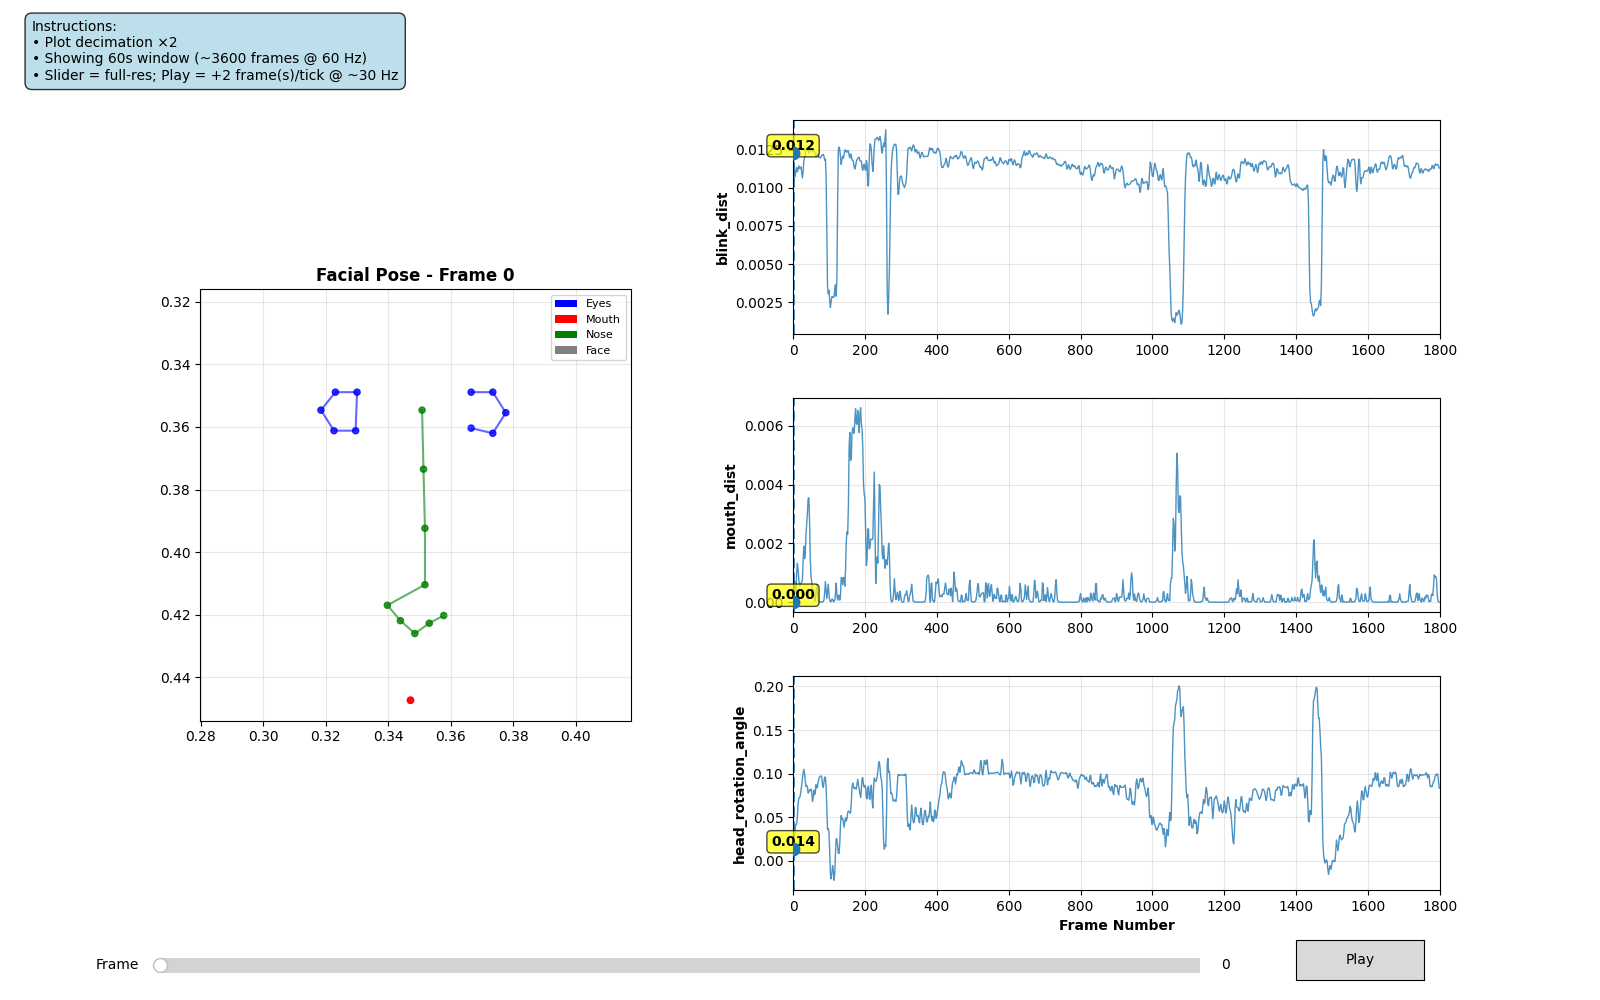

In [6]:
%matplotlib widget
import numpy as np
import pandas as pd
from utils import CFG
from utils.nb_utils import pick_norm_file, slice_first_seconds, series_num
from utils.viz_utils import create_interactive_pose_timeseries_viewer

# pick a normalized file (uses OUT_BASE/norm_screen)
norm_path = pick_norm_file(CFG.OUT_BASE)
if norm_path is None:
    raise FileNotFoundError(f"No normalized file found in {CFG.OUT_BASE}/norm_screen. Run normalization (Step 2) first.")

# load and trim to first 60s (or fewer if shorter)
df_pose = slice_first_seconds(pd.read_csv(norm_path), CFG.FPS, 60)

n = len(df_pose)
if n < 2:
    raise ValueError(f"Normalized file {norm_path.name} is too short ({n} frames) to display.")

# head rotation (eye corner vector, same indices as pipeline)
dx = (series_num(df_pose, "x", 46, n) - series_num(df_pose, "x", 37, n)).to_numpy(float)
dy = (series_num(df_pose, "y", 46, n) - series_num(df_pose, "y", 37, n)).to_numpy(float)
head_rotation_angle = np.arctan2(dy, dx)

# blink: average vertical eyelid gap L/R (indices consistent with OpenPose 68)
Ltop = (series_num(df_pose, "y", 38, n) + series_num(df_pose, "y", 39, n)) / 2.0
Lbot = (series_num(df_pose, "y", 41, n) + series_num(df_pose, "y", 42, n)) / 2.0
Rtop = (series_num(df_pose, "y", 44, n) + series_num(df_pose, "y", 45, n)) / 2.0
Rbot = (series_num(df_pose, "y", 47, n) + series_num(df_pose, "y", 48, n)) / 2.0

blink_L = (Ltop - Lbot).abs().to_numpy(float)
blink_R = (Rtop - Rbot).abs().to_numpy(float)
blink_dist = np.where(
    np.isfinite(blink_L) & np.isfinite(blink_R),
    (blink_L + blink_R) / 2.0,
    np.where(np.isfinite(blink_L), blink_L,
             np.where(np.isfinite(blink_R), blink_R, np.nan))
)

# mouth opening (63,67)
x63 = series_num(df_pose, "x", 63, n).to_numpy(float)
y63 = series_num(df_pose, "y", 63, n).to_numpy(float)
x67 = series_num(df_pose, "x", 67, n).to_numpy(float)
y67 = series_num(df_pose, "y", 67, n).to_numpy(float)
mouth_dist = np.sqrt((x67 - x63) ** 2 + (y67 - y63) ** 2)

# assemble feature DataFrame (one row per frame)
df_feats_orig = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

# launch the interactive viewer (uses CFG.FPS)
fig_orig = create_interactive_pose_timeseries_viewer(
    df_raw=df_pose,
    df_features=df_feats_orig,
    features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
    pose_sampling_hz=CFG.FPS,
    plot_downsample=2,
    window_seconds=60
)


## 5. Linear Metrics Analysis

### Calculate Linear Metrics (windowing & interocular scaling)
What this cell does:
- Uses the per-frame per-participant CSVs stored under `OUT_BASE/features/per_frame/original/`.
- Computes windowed linear metrics using a sliding window defined by:
    - `CFG.WINDOW_SECONDS` (typically 60 s),
    - `CFG.WINDOW_OVERLAP` (e.g., 0.5 for 50% overlap).
- Each output row corresponds to a single window for a single participant/condition, and contains aggregation measures such as RMS, mean absolute velocity, mean absolute acceleration, counts/durations, and interocular-scaled variants (if `SCALE_BY_INTEROCULAR` is `True`)

Important parameters / behavior:
- `SCALE_BY_INTEROCULAR` — if set, spatial features are normalized by the subject’s inter-ocular distance; this reduces between-subject scale differences.
- Window hop is computed as `hop = int(win * (1.0 - overlap))` (or at least 1).
- The function `compute_linear_from_perframe_dir` returns a summary of any windows that were dropped due to insufficient data.

In [7]:
# Compute linear metrics (60 s windows, 50% overlap) — fixed scale-by-interocular lookup
from pathlib import Path
import pandas as pd
import pose_pipeline as pp
from utils import CFG
from utils.features_utils import compute_linear_from_perframe_dir

# ---- interactive toggles ----
OVERWRITE = True   # set True to force recompute/overwrite existing linear CSVs
CFG.WINDOW_SECONDS = 60 # 60 second windows
CFG.WINDOW_OVERLAP = 0.5 # 50% overlap

# Paths
perframe_dir = Path(CFG.OUT_BASE) / "features" / "per_frame" / "original"
lm_out_dir = Path(CFG.OUT_BASE) / "linear_metrics"
lm_out_dir.mkdir(parents=True, exist_ok=True)
lm_out_path = lm_out_dir / "original_linear.csv"

compat_path = Path("data") / "linear_pose_metrics.csv"
compat_path.parent.mkdir(parents=True, exist_ok=True)

# Sanity checks
if not perframe_dir.exists() or not any(perframe_dir.glob("*.csv")):
    raise FileNotFoundError(f"No per-frame original files found in {perframe_dir}. Run per-frame feature extraction first.")

# Determine SCALE_BY_INTEROCULAR flag robustly
try:
    # prefer explicit export from utils if present
    from utils import SCALE_BY_INTEROCULAR as _SCALE_FLAG
except Exception:
    _SCALE_FLAG = getattr(pp, "SCALE_BY_INTEROCULAR", False)

print(f"Using SCALE_BY_INTEROCULAR = {_SCALE_FLAG}")

# If exists and not OVERWRITE, skip
if lm_out_path.exists() and not OVERWRITE:
    print(f"[skip] linear metrics exists -> {lm_out_path} (set OVERWRITE=True to force recompute)")
else:
    print(f"[run] computing linear metrics from per-frame dir -> {perframe_dir}")
    drops = compute_linear_from_perframe_dir(
        perframe_dir,
        lm_out_path,
        CFG.FPS,
        CFG.WINDOW_SECONDS,
        CFG.WINDOW_OVERLAP,
        _SCALE_FLAG
    )
    print(f"[OK] wrote linear metrics -> {lm_out_path}")
    print("Window drops summary:", drops)

# Write compatibility copy used by plotting/stats (overwrite if OVERWRITE=True or if missing)
if not compat_path.exists() or OVERWRITE:
    df_lin = pd.read_csv(lm_out_path)
    df_lin.to_csv(compat_path, index=False)
    print(f"[OK] wrote compatibility copy -> {compat_path}")
else:
    print(f"[skip] compatibility copy exists -> {compat_path}")

# Preview
display(pd.read_csv(lm_out_path).head())


Using SCALE_BY_INTEROCULAR = True
[run] computing linear metrics from per-frame dir -> data/processed/features/per_frame/original
[OK] wrote linear metrics -> data/processed/linear_metrics/original_linear.csv
Window drops summary: {'head_rotation_rad': 24, 'blink_aperture': 28, 'mouth_aperture': 43, 'pupil_dx': 28, 'pupil_dy': 28, 'pupil_metric': 28, 'center_face_magnitude': 28, 'center_face_x': 28, 'center_face_y': 28}
[OK] wrote compatibility copy -> data/linear_pose_metrics.csv


,source,participant,condition,window_index,t_start_frame,t_end_frame,head_rotation_rad_mean_abs_vel,head_rotation_rad_mean_abs_acc,head_rotation_rad_rms,blink_aperture_mean_abs_vel,...,pupil_metric_rms,center_face_magnitude_mean_abs_vel,center_face_magnitude_mean_abs_acc,center_face_magnitude_rms,center_face_x_mean_abs_vel,center_face_x_mean_abs_acc,center_face_x_rms,center_face_y_mean_abs_vel,center_face_y_mean_abs_acc,center_face_y_rms
0,original,3101,H,0,0,3600,0.164921,6.365455,0.038607,0.164120,...,0.006917,0.186980,3.981683,0.086667,0.146983,2.519421,0.063478,0.204100,4.558551,0.088780
1,original,3101,H,1,1800,5400,0.190859,7.186790,0.057514,0.196463,...,0.007558,0.217600,4.524362,0.113778,0.201444,3.398763,0.121704,0.244378,5.247650,0.102600
2,original,3101,H,2,3600,7200,0.182667,6.962998,0.056860,0.177639,...,0.007668,0.241974,4.727747,0.120392,0.207959,3.521033,0.124649,0.251820,5.240575,0.103646
3,original,3101,H,3,5400,9000,0.184181,7.180839,0.038310,0.193062,...,0.008327,0.286647,5.300003,0.151270,0.211170,3.589847,0.138453,0.288491,5.722594,0.119566
4,original,3101,H,4,7200,10800,0.199762,7.541044,0.039396,0.196924,...,0.008615,0.323545,5.666156,0.168866,0.264856,4.447377,0.148074,0.305048,5.871686,0.128646


### Figures and Stats (LMER)
What this cell does:
- Loads the aggregated linear metrics CSV (`data/linear_pose_metrics.csv` or `OUT_BASE/linear_metrics/original_linear.csv`).
- Prepares an interactive small GUI that allows the reviewer to:
    - select two metrics to visualize side-by-side (the figure layout mirrors the paper-style figures),
    - run the linear mixed model (LMER) for each selected metric using `lmerTest::lmer` in R via `rpy2`,
    - display `emmeans` results (condition means with CIs) and pairwise Tukey-adjusted contrasts,
    - or fall back to simple group means + 95% CIs if the R model fails (so you always get a plot for inspection).

In [2]:
# Interactive picker using window_index directly (no minute anywhere)
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, clear_output
import ipywidgets as widgets
import warnings
import traceback
import math

from utils import CFG
from utils.stats_utils import run_lmer_rpy2, barplot_ax

# --- load and prepare linear pose CSV (inline) ---
pose_path = Path("data") / "linear_pose_metrics.csv"
if not pose_path.exists():
    raise FileNotFoundError(f"Pose linear metrics not found at {pose_path}; run the linear computation step first.")

pose_df = pd.read_csv(pose_path)
print(f"Loaded pose_df: {pose_df.shape[0]} rows x {pose_df.shape[1]} cols")

# Ensure participant col exists
if "participant" not in pose_df.columns:
    if "Participant ID" in pose_df.columns:
        pose_df = pose_df.rename(columns={"Participant ID": "participant"})
        print("Renamed 'Participant ID' -> 'participant'")
    else:
        raise KeyError("No 'participant' or 'Participant ID' column found in linear_pose_metrics.csv")

# drop sentinel window_index rows if present
if "window_index" in pose_df.columns:
    pose_df = pose_df[pose_df["window_index"] != 15]

# session ordering via participant_info.csv if present
session_info_path = Path("data") / "participant_info.csv"
session_order_map = {}
session_order_numeric_map = {"LMH": 1, "LHM": 2}
if session_info_path.exists():
    si = pd.read_csv(session_info_path)
    if {"Session1", "Session2", "Session3"}.issubset(si.columns):
        si["session_order"] = si["Session1"].str[0] + si["Session2"].str[0] + si["Session3"].str[0]
    if "session_order" in si.columns:
        session_order_map = si.set_index("Participant ID")["session_order"].to_dict()
        observed = sorted(si["session_order"].dropna().unique().tolist())
        if set(["LMH", "LHM"]).issubset(set(observed)):
            session_order_numeric_map = {"LMH": 1, "LHM": 2}
        else:
            session_order_numeric_map = {v: i+1 for i, v in enumerate(observed)}

# Ensure window_index exists / is numeric (we keep window_index; no minute)
if "window_index" not in pose_df.columns:
    pose_df["window_index"] = 0
    warnings.warn("No 'window_index' column found: setting window_index = 0 for all rows")
pose_df["window_index"] = pd.to_numeric(pose_df["window_index"], errors="coerce").fillna(0).astype(int)

# map session_order if available (and create numeric)
if session_order_map:
    pose_df["session_order"] = pose_df["participant"].map(session_order_map)
    pose_df["session_order_numeric"] = pose_df["session_order"].map(session_order_numeric_map).fillna(0).astype(float)
    print("Mapped session_order and session_order_numeric from participant_info.csv")
else:
    if "session_order_numeric" not in pose_df.columns:
        pose_df["session_order_numeric"] = 0.0
        warnings.warn("No participant_info.csv: setting session_order_numeric = 0 for all rows")
    else:
        pose_df["session_order_numeric"] = pd.to_numeric(pose_df["session_order_numeric"], errors="coerce").fillna(0.0)

# standardize condition column
cond_map = {"low": "L", "moderate": "M", "hard": "H", "l": "L", "m": "M", "h": "H"}
if "condition" in pose_df.columns:
    pose_df["condition"] = pose_df["condition"].astype(str).str.strip().str.lower().map(cond_map).fillna(pose_df["condition"])
else:
    warnings.warn("No 'condition' column found — model may not behave as intended")

# --- candidate numeric columns for selection: exclude control columns ---
non_metric_cols = {"participant", "condition", "window_index", "session_order", "session_order_numeric"}
candidates = [c for c in pose_df.columns if c not in non_metric_cols and pd.api.types.is_numeric_dtype(pose_df[c])]
if not candidates:
    raise RuntimeError("No numeric candidate metrics found in linear_pose_metrics.csv")

# Build widgets
w_metric1 = widgets.Dropdown(options=candidates, value=candidates[0], description="Metric 1:")
w_metric2 = widgets.Dropdown(options=candidates, value=(candidates[1] if len(candidates)>1 else candidates[0]), description="Metric 2:")
w_run = widgets.Button(description="Run stats & plot", button_style="primary")
out = widgets.Output(layout={"border": "1px solid gray", "max_height":"600px", "overflow":"auto"})

# Interactive run code with fallback to group means on R failure
run_code = r"""
clear_output(wait=True)
display(widgets.HBox([w_metric1, w_metric2, w_run]))
display(out)
with out:
    out.clear_output()
    import math, sys, traceback
    print(f"Running stats for: {w_metric1.value}  and  {w_metric2.value}\n")
    selected = [w_metric1.value, w_metric2.value]
    metrics_labels = []
    results = {}
    for metric in selected:
        label = metric.replace("_", " ").title()
        metrics_labels.append((metric, label))
        if metric not in pose_df.columns:
            print(f"[WARN] {metric} missing from dataframe — skipping")
            results[metric] = {"pvals": {}, "means": {}, "cis": {}}
            continue

        # prepare df_model which exposes window_index & session_order_numeric to R exactly as needed
        df_model = pose_df.copy()
        df_model["window_index"] = pd.to_numeric(df_model["window_index"], errors="coerce").fillna(0.0).astype(float)
        df_model["session_order_numeric"] = pd.to_numeric(df_model.get("session_order_numeric", 0), errors="coerce").fillna(0.0).astype(float)

        # Attempt the R model; capture exceptions and print traceback / repr(e)
        try:
            pairwise_p, means, cis = run_lmer_rpy2(df_model, metric, label)
            # If returned dicts are empty or missing 'means' treat as failure to be safe
            if not means:
                raise RuntimeError("run_lmer_rpy2 returned empty results")
            results[metric] = {"pvals": pairwise_p, "means": means, "cis": cis}
            print(f"[OK] R model succeeded for {metric}\n")
        except Exception as e:
            print(f"[ERROR] R model failed for {metric}: {e}\n")
            traceback.print_exc()
            # FALLBACK: compute simple group means and 95% CI (sem*1.96) for condition groups
            try:
                grp = df_model.groupby("condition", observed=False)[metric]
                means_pd = grp.mean()
                sem_pd = grp.sem(ddof=0)
                # build outputs keyed by 'L','M','H'
                means = {}
                cis = {}
                for lvl in ["L","M","H"]:
                    if lvl in means_pd.index:
                        m = float(means_pd.loc[lvl])
                        se = float(sem_pd.loc[lvl]) if (lvl in sem_pd.index) else float("nan")
                        means[lvl] = m
                        cis[lvl] = (m - 1.96*se if not math.isnan(se) else float("nan"),
                                    m + 1.96*se if not math.isnan(se) else float("nan"))
                    else:
                        means[lvl] = float("nan")
                        cis[lvl] = (float("nan"), float("nan"))
                # pairwise pvals: set NaN (we didn't compute)
                pairwise_p = {}
                results[metric] = {"pvals": pairwise_p, "means": means, "cis": cis}
                print("[FALLBACK] Plotted group means + 95% CI (sem*1.96). This is NOT the LMER result.\n")
            except Exception as e2:
                print(f"[ERROR] Fallback summary failed for {metric}: {e2}\n")
                results[metric] = {"pvals": {}, "means": {}, "cis": {}}

    # Now plot side-by-side using barplot_ax (same formatting)
    col_pal = ['#c6dbef', '#6baed6', '#2171b5']
    FIGSIZE = (6, 3)
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharey=False, constrained_layout=True)

    for ax, (metric, label) in zip(axes, metrics_labels):
        res = results.get(metric, {"pvals": {}, "means": {}, "cis": {}})
        # If we have no means at all -> message and grey panel
        if not res["means"] or all(math.isnan(v) for v in res["means"].values()):
            ax.text(0.5, 0.5, f"Missing results for {metric}", ha='center', va='center')
            ax.set_axis_off()
            continue
        order = ['L', 'M', 'H']
        means = [res["means"].get(lvl, math.nan) for lvl in order]
        cis = [res["cis"].get(lvl, (math.nan, math.nan)) for lvl in order]
        sems = []
        for ci in cis:
            if ci is not None and isinstance(ci, (tuple, list)) and len(ci) == 2 and not math.isnan(ci[0]) and not math.isnan(ci[1]):
                sems.append((ci[1] - ci[0]) / 3.92)
            else:
                sems.append(math.nan)
        pvals = (
            res["pvals"].get(('L','M'), math.nan),
            res["pvals"].get(('L','H'), math.nan),
            res["pvals"].get(('M','H'), math.nan)
        )
        barplot_ax(ax, means, sems, pvals, label, metric_name=metric, colors=col_pal, bar_width=0.6)

    fig.suptitle("Pose measures", fontweight='bold', fontsize=16)
    plt.show()
"""

# attach on_click using a lambda that execs the run_code in the current scope
w_run.on_click(lambda b: exec(run_code, globals(), locals()))

# display UI
display(widgets.HBox([w_metric1, w_metric2, w_run]))
display(out)

Output(layout=Layout(border_bottom='1px solid gray', border_left='1px solid gray', border_right='1px solid gra…